In [1]:
import os, glob, cv2, math, csv, tqdm, random
import numpy as np
import keras
from keras import backend as k
from keras import applications, optimizers, losses, layers
from keras import layers ,losses
from keras.layers import Dropout, Input, concatenate, Dense, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.utils import generic_utils

from keras.optimizers import Adam
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def data_generator(image_path, lab_path, batch):
    
    dir_lists = sorted(os.listdir(image_path))
    total = []
    for i in dir_lists:
        paths = sorted(glob.glob(image_path+'/%s/*.png'%i))
        x = [[paths[i], paths[i+1]] for i in range(len(paths)-1)]
        for j in x:
            total.append(j)    

    dir_lists_lab = sorted(os.listdir(lab_path))
    total_lab = []
    for i in dir_lists_lab:
        paths_lab = sorted(glob.glob(lab_path+'/%s/*.png'%i))
        x = [[paths_lab[i]] for i in range(len(paths_lab))]
        for j in x:
            total_lab.append(j)
            
    idx = list(range(0,len(total)))
    random.shuffle(idx)
    while 1:
        idx_batch = random.sample(idx,batch)
        
        bat_img = []
        bat_lab = []
        
        for i in idx_batch:
            img = cv2.resize(np.concatenate((cv2.imread(total[i][0]),cv2.imread(total[i][1])),axis = 2),(512,384))/255.
            lab = cv2.resize(cv2.imread(total_lab[i][0]),(512,384))/255.
            bat_img.append(img)
            bat_lab.append(lab) 
        yield np.array(bat_img), [np.array([cv2.resize(i, (32, 24)) for i in bat_lab]),
                                  np.array([cv2.resize(i, (64, 48)) for i in bat_lab]), 
                                 np.array([cv2.resize(i, (128, 96)) for i in bat_lab]), 
                                 np.array([cv2.resize(i, (256, 192)) for i in bat_lab]),
                                 np.array([cv2.resize(i, (512, 384)) for i in bat_lab])]

In [3]:
def generator(inputs):
    conv1 = Conv2D(64, 7,  activation = 'relu', padding = 'same', strides=(2, 2))(inputs)
    conv2 = Conv2D(128, 5,  activation = 'relu', padding = 'same', strides=(2, 2))(conv1)
    conv3 = Conv2D(256, 5,  activation = 'relu', padding = 'same', strides=(2, 2))(conv2)
    conv3_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', strides=(1, 1))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(2, 2))(conv3_1)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(1, 1))(conv4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(2, 2))(conv4_1)
    conv5_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(1, 1))(conv5)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', strides=(2, 2))(conv5_1)

    deconv5 = Conv2DTranspose(512, 4, activation = 'relu', padding = 'same',strides=(2, 2))(conv6)
    merge5 = concatenate([deconv5,conv5_1], axis = 3)
    aux1 = Conv2DTranspose(3, 4, activation = 'sigmoid', padding = 'same' , name = 'aux1', strides=(2, 2))(merge5)

    deconv4 = Conv2DTranspose(256, 4, activation = 'relu', padding = 'same',strides=(2, 2))(merge5)
    merge4 = concatenate([deconv4,conv4_1,aux1], axis = 3)
    aux2 = Conv2DTranspose(3, 4, activation = 'sigmoid', padding = 'same' , name = 'aux2', strides=(2, 2))(merge4)
    
    deconv3 = Conv2DTranspose(128, 4, activation = 'relu', padding = 'same',strides=(2, 2))(merge4)
    merge3 = concatenate([deconv3,conv3_1,aux2], axis = 3)
    aux3 = Conv2DTranspose(3, 4, activation = 'sigmoid', padding = 'same' , name = 'aux3', strides=(2, 2))(merge3)
    
    deconv2 = Conv2DTranspose(64, 4, activation = 'relu', padding = 'same',strides=(2, 2))(merge3)    
    merge2 = concatenate([deconv2,conv2,aux3], axis = 3)
    aux4 = Conv2DTranspose(3, 4, activation = 'sigmoid', padding = 'same' , name = 'aux4', strides=(2, 2))(merge2)
    
    deconv1 = Conv2DTranspose(32, 4, activation = 'relu', padding = 'same',strides=(2, 2))(merge2)    
    merge1 = concatenate([deconv1,conv1,aux4], axis = 3)
    output = Conv2DTranspose(3, 4, activation = 'sigmoid', padding = 'same' , name = 'output', strides=(2, 2))(merge1)

    model = Model(inputs = inputs, outputs = [aux1,aux2,aux3,aux4,output])
    return model

def discriminator(inputs):
    conv1 = Conv2D(64, 7,  activation = 'relu', padding = 'same', strides=(2, 2))(inputs)
    conv2 = Conv2D(128, 5, activation = 'relu', padding = 'same', strides=(2, 2))(conv1)
    conv3 = Conv2D(256, 5, activation = 'relu', padding = 'same', strides=(2, 2))(conv2)
    conv3_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', strides=(1, 1))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(2, 2))(conv3_1)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(1, 1))(conv4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(2, 2))(conv4_1)
    conv5_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', strides=(1, 1))(conv5)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', strides=(2, 2))(conv5_1)
    
    fc1 = GlobalAveragePooling2D()(conv6)
    fc1_1 = Dense(512, activation= 'relu')(fc1)
    fc1_1 = Dense(128, activation= 'relu')(fc1_1)
    output = Dense(1, activation= 'sigmoid')(fc1_1)
    
    model = Model(inputs = inputs, outputs = output)
    return model

def gen_to_dis(x, generator, discriminator):
    gened_img = generator(x)
    outputs1 = discriminator(gened_img[-1])
    return gened_img, outputs1

In [4]:
gen_input = Input(shape=(384,512,6))
dis_input = Input(shape=(384,512,3))

model_gen = generator(gen_input)
model_dis = discriminator(dis_input)

all_output = gen_to_dis(gen_input, model_gen, model_dis)
model_all = Model(inputs = gen_input, outputs=[all_output[0][0], all_output[0][1],
                                               all_output[0][2], all_output[0][3], 
                                               all_output[0][4], all_output[1]])

In [5]:
model_dis.compile(optimizer = Adam(lr = 0.0002), loss = 'binary_crossentropy')
model_dis.trainable = False

model_all.compile(optimizer = Adam(lr = 0.0002), 
                  loss = ['mse','mse','mse','mse','mse','binary_crossentropy'],
                  loss_weights=[0.005,0.01,0.02,0.08,0.32,1])
model_dis.trainable = True

In [6]:
image_path = '../MPI/training/train'
lab_path = '../MPI/training/train_lab'

val_image_path = '../MPI/training/val'
val_lab_path = '../MPI/training/val_lab'

batch = 16
train = data_generator(image_path, lab_path, batch)

val = data_generator(val_image_path, val_lab_path, batch)


Epoch 1/3
10/10 [==============================] - 2s 187ms/step - dis loss: 0.6875 - gen loss: 0.6807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


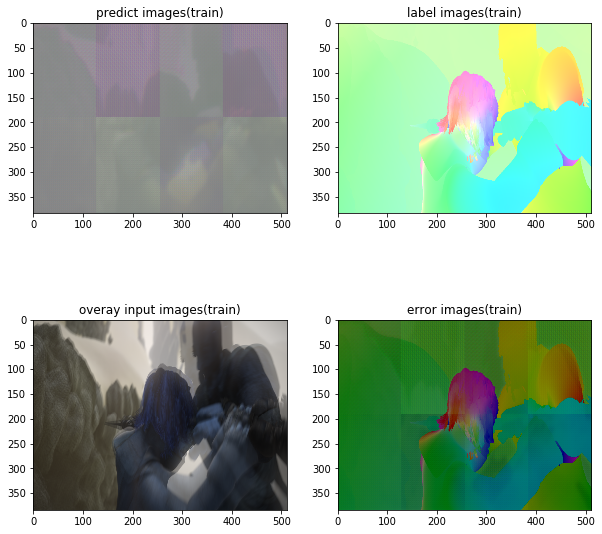

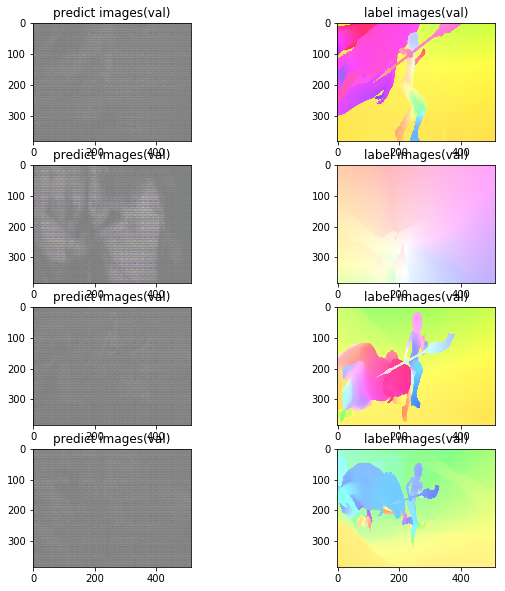


Epoch 2/3
 9/10 [==========================>...] - ETA: 0s - dis loss: 0.6808 - gen loss: 0.64185

In [ ]:
epochs = 3
num_iter = 10
top_gen_loss = float('inf')
total_dis_loss = []
total_gen_loss = []
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch+1, epochs))
    
    mean_dis_loss = 0
    mean_gen_loss = 0
    
    for i in range(num_iter):
        progbar = generic_utils.Progbar(num_iter)
        #print('Epoch {}/{}'.format(i, num_iter))
        gen_input_imgs, gen_labels = next(train)
        gened_img = model_gen.predict(gen_input_imgs)
        
        
        #dix_idx = np.random.choice(len(tr_y), batch_size)
        sample_dis_img = np.concatenate((gen_labels[-1], gened_img[-1]), axis=0)
        sample_dix_lab = np.zeros([2*batch, 1])
        sample_dix_lab[:batch] = 1. 
        
        dis_loss = model_dis.train_on_batch(sample_dis_img, sample_dix_lab)

        model_dis.trainable = False
        sample_dis_lab = np.ones([batch, 1])
        
        all_loss = model_all.train_on_batch(gen_input_imgs, [gen_labels[0],
                                                             gen_labels[1],
                                                             gen_labels[2],
                                                             gen_labels[3],
                                                             gen_labels[4],
                                                             sample_dis_lab])

        model_dis.trainable = True
        
        mean_dis_loss += dis_loss
        mean_gen_loss += all_loss[0]
        
        total_dis_loss.append(dis_loss)
        total_gen_loss.append(all_loss[0])
                
        progbar.update(i+1, [('dis loss', mean_dis_loss/(i+1)), ('gen loss', mean_gen_loss/(i+1))])
        
    test_img, test_lab= next(train)
    test_p = model_gen.predict(test_img)    
    plt.figure(figsize = (10,10))

    plt.subplot(221)
    plt.imshow(test_p[4][0])
    plt.title("predict images(train)")
    plt.subplot(222)
    plt.imshow(test_lab[4][0])
    plt.title("label images(train)")
    plt.subplot(223)
    plt.imshow((test_img[0,:,:,:3]+test_img[0,:,:,3:])/2)
    plt.title("overay input images(train)")
    plt.subplot(224)
    plt.imshow(test_lab[4][0]-test_p[4][0])
    plt.title("error images(train)")
    plt.show()

    
    test_img, test_lab= next(val)
    test_p = model_gen.predict(test_img)
    
    plt.figure(figsize = (10,10))
    plt.subplot(421)
    plt.imshow(test_p[4][0])
    plt.title("predict images(val)")
    plt.subplot(422)
    plt.imshow(test_lab[4][0])
    plt.title("label images(val)")
    plt.subplot(423)
    plt.imshow(test_p[4][1])
    plt.title("predict images(val)")
    plt.subplot(424)
    plt.imshow(test_lab[4][1])
    plt.title("label images(val)")
    plt.subplot(425)
    plt.imshow(test_p[4][2])
    plt.title("predict images(val)")
    plt.subplot(426)
    plt.imshow(test_lab[4][2])
    plt.title("label images(val)")
    plt.subplot(427)
    plt.imshow(test_p[4][3])
    plt.title("predict images(val)")
    plt.subplot(428)
    plt.imshow(test_lab[4][3])
    plt.title("label images(val)")
    plt.show()


In [ ]:
model_gen.summary()